In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
# Libraries and dependencies

import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from torchvision import models
import torchvision.transforms.functional as F
from matplotlib import cm as CM
from image import *
import torch
import torch.nn as nn
from tqdm import tqdm
from torchvision import datasets, transforms
import sys
sys.path.append('/content/drive/MyDrive/ADIP')
from model import CSRNet
from utils import save_net, load_net
from math import sqrt
%matplotlib inline

In [22]:
# define the location of dataset

root = '/content/drive/MyDrive/ADIP/ShanghaiTech_Crowd_Counting_Dataset/'

part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')

# if Part B was used to train model, change path set to point to Prt B test images
path_sets = [part_A_test]

In [23]:
# define the test image path for Part A
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
       img_paths.append(img_path)

In [27]:
# set CSRNet as model and copy to GPU
# download vgg-16 frontend weights

model = CSRNet().cuda()

In [28]:
# load the trained weights

checkpoint = torch.load('/content/drive/MyDrive/ADIP/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/0model_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [33]:
# Dataloader

transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ])

In [38]:
# evaluate model performance using MAE (Mean Average Error) metric and RMSE (Root Mean Square Error)

mae = 0
mse=0
for i in tqdm(range(len(img_paths))):
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth))
    mse += (output.detach().cpu().sum().numpy()-np.sum(groundtruth)) ** 2
print (mae/len(img_paths), end=" ", flush=True)
print (sqrt(mse/len(img_paths)))

100%|██████████| 182/182 [00:19<00:00,  9.32it/s]

75.69090073973268 112.36890605378518


Original Image


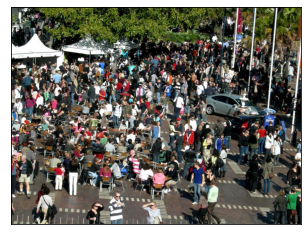

Ground truth


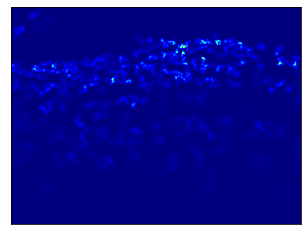

Estimated Density Map


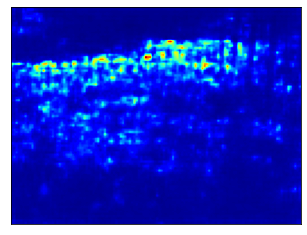

Original Count :  498
Predicted Count :  469


In [39]:
# try model prediction on a single image
# point path to test images 


# Original image
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/ADIP/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data/images/IMG_10.jpg'))
plt.xticks([])
plt.yticks([])
plt.show()

# Ground truth map
temp = h5py.File('/content/drive/MyDrive/ADIP/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data/ground_truth/IMG_10.h5', 'r')
temp_1 = np.asarray(temp['density'])
print("Ground truth")
plt.imshow(temp_1,cmap = CM.jet)
plt.xticks([])
plt.yticks([])
plt.show()

# Estimated map
img = transform(Image.open('/content/drive/MyDrive/ADIP/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data/images/IMG_10.jpg').convert('RGB')).cuda()
output = model(img.unsqueeze(0))
print("Estimated Density Map")
imgg =output.squeeze()
plt.imshow(imgg.detach().cpu(),cmap = CM.jet)
plt.xticks([])
plt.yticks([])
plt.show()

print("Original Count : ",int(np.sum(temp_1)) + 1)
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))